In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import torch
import os

torch.set_default_dtype(torch.double)


##### Define BIMT networks #####
class BioLinear(nn.Module):
    # BioLinear is just Linear, but each neuron comes with coordinates.
    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1):
        super(BioLinear, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold # in_fold is the number of folds applied to input vectors. It only affects coordinates, not computations.
        self.out_fold = out_fold # out_fold is the number of folds applied to output vectors. It only affects coordinates, not computations.
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0
        #compute in_cor, shape: (in_dim)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        self.in_coordinates = torch.tensor(list(np.linspace(1/(2*in_dim_fold), 1-1/(2*in_dim_fold), num=in_dim_fold))*in_fold, dtype=torch.float) # place input neurons in 1D Euclidean space
        self.out_coordinates = torch.tensor(list(np.linspace(1/(2*out_dim_fold), 1-1/(2*out_dim_fold), num=out_dim_fold))*out_fold, dtype=torch.float) # place output neurons in 1D Euclidean space
        self.input = None
        self.output = None
        
    def forward(self, x):
        self.input = x.clone()
        self.output = self.linear(x).clone()
        return self.output
    
    
class BioMLP(nn.Module):
    # BioMLP is just MLP, but each neuron comes with coordinates.
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth
                 
        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1

        linear_list = []
        for i in range(self.depth):
            if i == 0:
                linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=1))
                
            else:
                linear_list.append(BioLinear(shp[i], shp[i+1]))
        self.linears = nn.ModuleList(linear_list)
        
        
        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size))
        
        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.1 # distance between two nearby layers
        self.in_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = torch.nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 12 # the number of important neurons (used in Swaps)
        self.token_embedding = token_embedding
        self.n_parameters = sum(p.numel() for p in self.parameters())
        self.original_params = None

    def forward(self, x):
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        #f = torch.nn.SiLU()
        f = torch.nn.ReLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)
        
        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]
        
        return x
    
    def get_linear_layers(self):
        return self.linears
    
    def get_cc(self, weight_factor=1.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        # bias_penalize = True penalizes biases, otherwise doesn't penalize biases
        # no_penalize_last = True means do not penalize last linear layer, False means penalize last layer.
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i]
            dist = torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0))
            cc += torch.sum(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.sum(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.sum(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc
    
    def swap_weight(self, weights, j, k, swap_type="out"):
        # Given a weight matrix, swap the j^th and k^th neuron in inputs/outputs when swap_type = "in"/"out"
        with torch.no_grad():  
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))
            
    def swap_bias(self, biases, j, k):
        # Given a bias vector, swap the j^th and k^th neuron.
        with torch.no_grad():  
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp
    
    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron. 
        # Note: n layers of weights means n+1 layers of neurons.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : incoming weights, outgoing weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        # in the ith layer (of neurons), get the top k important neurons (have large weight connections with other neurons)
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index
    
    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)
            
    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id:
            self.relocate_ij(i,j)
            
    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)
            
    def plot(self, mode="internal", model=None):
        fig, ax = plt.subplots(figsize=(3,3))
        #ax = plt.gca()
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        if mode == "internal":
            linears = self.linears
        else:
            linears = model.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight
            p_shp = p.shape
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num):
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=np.minimum(1*np.abs(p[i,j].detach().numpy()), 1), color="blue" if p[i,j]>0 else "red")
                else:
                    for j in range(fold_num):
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=np.minimum(1*np.abs(p[i,j].detach().numpy()), 1), color="blue" if p[i,j]>0 else "red")
                    
        ax.axis('off')
        
        
    def plot_weights(self, mode="internal", model=None):
        fig, ax = plt.subplots(figsize=(3,3))
        #ax = plt.gca()
        shp = self.shp
        s = 1/(2*max(shp))
        for j in range(len(shp)):
            N = shp[j]
            if j == 0:
                in_fold = self.linears[j].in_fold
                N = int(N/in_fold)
            for i in range(N):
                if j == 0:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j+0.02*fold-0.01), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)
                else:
                    for fold in range(in_fold):
                        circle = Ellipse((1/(2*N)+i/N, 0.1*j), s, s/10*((len(shp)-1)+0.4), color='black')
                        ax.add_patch(circle)


        plt.ylim(-0.02,0.1*(len(shp)-1)+0.02)
        plt.xlim(-0.02,1.02)

        if mode == "internal":
            linears = self.linears
        elif mode == "external":
            linears = model.linears
        for ii in range(len(linears)):
            biolinear = linears[ii]
            p = biolinear.linear.weight
            p_shp = p.shape
            p = p/torch.abs(p).max()
            in_fold = biolinear.in_fold
            fold_num = int(p_shp[1]/in_fold)
            for i in range(p_shp[0]):
                if ii == 0:
                    for fold in range(in_fold):
                        for j in range(fold_num):
                            plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii+0.02*fold-0.01], lw=np.minimum(1*np.abs(p[i,j].detach().numpy()), 1), color="blue" if p[i,j]>0 else "red")
                else:
                    for j in range(fold_num):
                        plt.plot([1/(2*p_shp[0])+i/p_shp[0], 1/(2*fold_num)+j/fold_num], [0.1*(ii+1),0.1*ii], lw=np.minimum(1*np.abs(p[i,j].detach().numpy()), 1), color="blue" if p[i,j]>0 else "red")
                    
        ax.axis('off')
        
        
    def thresholding(self, threshold, checkpoint = True):
        # snap too small weights (smaller than threshold) to zero. Useful for pruning.
        num = 0
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            for param in self.parameters():
                num += torch.sum(torch.abs(param)>threshold)
                param.data = param*(torch.abs(param)>threshold)
        return num
                
    def intervening(self, i, pos, value, ptype="weight", checkpoint = True):
        if checkpoint:
            self.original_params = [param.clone() for param in self.parameters()]
        with torch.no_grad():
            if ptype == "weight":
                self.linears[i].linear.weight[pos] = value
            elif ptype == "bias":
                self.linears[i].linear.bias[pos] = value
                
    def revert(self):
        with torch.no_grad():
            for param, original_param in zip(self.parameters(), self.original_params):
                param.data.copy_(original_param.data)

In [26]:
# ##### define datasets #####
# # mult-task sparse parity

# p = 2 #modulo p
# n_control = 4 #number of control bits = number of tasks
# n_task = 8 #number of task bits
# k = 2 # sparse k; add k numbers
# indices = np.array([[0,1],[2,3],[4,5],[6,7]]) # indicate indices for tasks bits for each task

# assert indices.shape[0] == n_control
# assert indices.shape[1] == k

# def num2bin(x):
#     arr = []
#     for i in range(n_task):
#         k = (x/p).astype(int)
#         r = x % p
#         x = k
#         arr.append(r)
#     return arr
        
# task_bits = np.transpose(np.array(num2bin(np.arange(p**n_task))))
# target = np.sum(task_bits[:,indices], axis=2) % p

# intput_bits = []
# label_bits = []
# for i in range(n_control):
#     new_bits = np.concatenate([np.eye(n_control)[np.array([i] * task_bits.shape[0])], task_bits], axis=1)
#     if i == 0:
#         input_bits = new_bits
#         label_bits = target[:,i]
#     else:
#         input_bits = np.concatenate([input_bits, new_bits], axis=0)
#         label_bits = np.concatenate([label_bits, target[:,i]], axis=0)

# # For other tasks, write your own create_dataset function to generate inputs and labels
# inputs = torch.tensor(input_bits, dtype=torch.double, requires_grad=True)
# labels = torch.tensor(label_bits, dtype=torch.double, requires_grad=True).unsqueeze(dim=1)

In [27]:
version = "bit_xor"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [28]:
def load_data(mode='train'):
    data = np.loadtxt(f'../{version}/data_{mode}.txt', dtype='str')
    inputs = data[:,:2]
    labels = data[:,2]

    def strs2mat(strings):
        num = strings.shape[0]
        mat = []
        for i in range(num):
            mat.append([*strings[i]])
        return mat

    inputs_ = np.transpose(np.array([strs2mat(inputs[:,0]), strs2mat(inputs[:,1])]), (1,2,0)).astype('float')
    labels_ = np.array(strs2mat(labels))[:,:,np.newaxis].astype('float')

    return inputs_, labels_

inputs_train, labels_train = load_data(mode='train')
inputs_test, labels_test = load_data(mode='test')

inputs_train = torch.tensor(inputs_train, dtype=torch.float64, requires_grad=True).to(device)
labels_train = torch.tensor(labels_train, dtype=torch.float64, requires_grad=True).to(device)
inputs_test = torch.tensor(inputs_test, dtype=torch.float64, requires_grad=True).to(device)
labels_test = torch.tensor(labels_test, dtype=torch.float64, requires_grad=True).to(device)

In [29]:
inputs, labels = inputs_train.reshape(819,-1), labels_train.reshape(819,-1)

In [30]:
inputs.shape, labels.shape

(torch.Size([819, 12]), torch.Size([819, 6]))

step = 0 | total loss: 6.17e-01 | train loss: 5.70e-01 | reg: 4.68e+01 


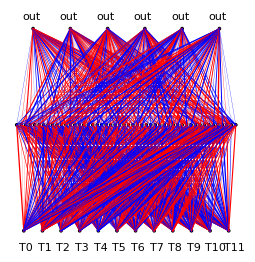

step = 200 | total loss: 1.36e-01 | train loss: 1.06e-01 | reg: 3.01e+01 
step = 400 | total loss: 2.39e-02 | train loss: 2.00e-03 | reg: 2.19e+01 
step = 600 | total loss: 1.49e-02 | train loss: 2.73e-04 | reg: 1.47e+01 
step = 800 | total loss: 1.08e-02 | train loss: 8.04e-05 | reg: 1.07e+01 
step = 1000 | total loss: 9.00e-03 | train loss: 4.38e-05 | reg: 8.95e+00 
step = 1200 | total loss: 7.92e-03 | train loss: 2.62e-05 | reg: 7.89e+00 
step = 1400 | total loss: 7.23e-03 | train loss: 2.44e-05 | reg: 7.21e+00 
step = 1600 | total loss: 6.67e-03 | train loss: 1.86e-05 | reg: 6.65e+00 
step = 1800 | total loss: 6.22e-03 | train loss: 1.46e-05 | reg: 6.20e+00 
step = 2000 | total loss: 5.92e-03 | train loss: 1.25e-05 | reg: 5.90e+00 


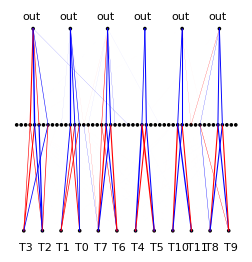

step = 2200 | total loss: 5.65e-03 | train loss: 8.02e-06 | reg: 5.64e+00 
step = 2400 | total loss: 5.39e-03 | train loss: 6.85e-06 | reg: 5.38e+00 
step = 2600 | total loss: 5.21e-03 | train loss: 6.61e-06 | reg: 5.20e+00 
step = 2800 | total loss: 5.02e-03 | train loss: 7.21e-06 | reg: 5.02e+00 
step = 3000 | total loss: 4.88e-03 | train loss: 6.27e-06 | reg: 4.87e+00 
step = 3200 | total loss: 4.73e-03 | train loss: 6.03e-06 | reg: 4.72e+00 
step = 3400 | total loss: 4.62e-03 | train loss: 6.40e-06 | reg: 4.61e+00 
step = 3600 | total loss: 4.46e-03 | train loss: 4.95e-06 | reg: 4.46e+00 
step = 3800 | total loss: 4.41e-03 | train loss: 4.45e-06 | reg: 4.40e+00 
step = 4000 | total loss: 4.36e-03 | train loss: 4.52e-06 | reg: 4.36e+00 


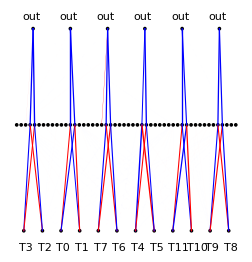

step = 4200 | total loss: 4.35e-03 | train loss: 4.56e-06 | reg: 4.34e+00 
step = 4400 | total loss: 4.34e-03 | train loss: 3.96e-06 | reg: 4.34e+00 
step = 4600 | total loss: 4.33e-03 | train loss: 3.97e-06 | reg: 4.33e+00 
step = 4800 | total loss: 4.32e-03 | train loss: 4.69e-06 | reg: 4.32e+00 
step = 5000 | total loss: 4.32e-03 | train loss: 5.14e-06 | reg: 4.32e+00 
step = 5200 | total loss: 4.32e-03 | train loss: 4.57e-06 | reg: 4.31e+00 
step = 5400 | total loss: 4.32e-03 | train loss: 4.45e-06 | reg: 4.32e+00 
step = 5600 | total loss: 4.31e-03 | train loss: 4.71e-06 | reg: 4.31e+00 
step = 5800 | total loss: 4.32e-03 | train loss: 5.65e-06 | reg: 4.32e+00 
step = 6000 | total loss: 4.31e-03 | train loss: 4.09e-06 | reg: 4.31e+00 


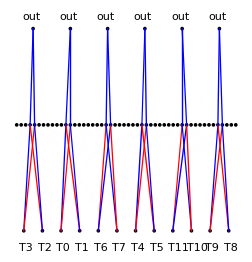

step = 6200 | total loss: 4.32e-03 | train loss: 4.43e-06 | reg: 4.31e+00 
step = 6400 | total loss: 4.31e-03 | train loss: 4.32e-06 | reg: 4.31e+00 
step = 6600 | total loss: 4.32e-03 | train loss: 4.73e-06 | reg: 4.31e+00 
step = 6800 | total loss: 4.31e-03 | train loss: 3.96e-06 | reg: 4.31e+00 
step = 7000 | total loss: 4.31e-03 | train loss: 4.25e-06 | reg: 4.31e+00 
step = 7200 | total loss: 4.31e-03 | train loss: 4.59e-06 | reg: 4.31e+00 
step = 7400 | total loss: 4.32e-03 | train loss: 5.15e-06 | reg: 4.31e+00 
step = 7600 | total loss: 4.31e-03 | train loss: 4.60e-06 | reg: 4.31e+00 
step = 7800 | total loss: 4.31e-03 | train loss: 5.24e-06 | reg: 4.31e+00 
step = 8000 | total loss: 4.32e-03 | train loss: 4.66e-06 | reg: 4.31e+00 


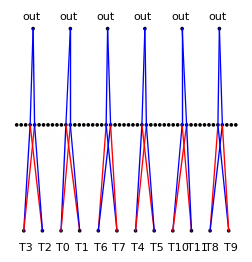

step = 8200 | total loss: 4.31e-03 | train loss: 4.25e-06 | reg: 4.31e+00 
step = 8400 | total loss: 4.31e-03 | train loss: 4.85e-06 | reg: 4.31e+00 
step = 8600 | total loss: 4.31e-03 | train loss: 4.57e-06 | reg: 4.31e+00 
step = 8800 | total loss: 4.31e-03 | train loss: 4.27e-06 | reg: 4.31e+00 
step = 9000 | total loss: 4.31e-03 | train loss: 3.70e-06 | reg: 4.31e+00 
step = 9200 | total loss: 4.31e-03 | train loss: 4.05e-06 | reg: 4.31e+00 
step = 9400 | total loss: 4.31e-03 | train loss: 3.94e-06 | reg: 4.31e+00 
step = 9600 | total loss: 4.32e-03 | train loss: 5.58e-06 | reg: 4.32e+00 
step = 9800 | total loss: 4.32e-03 | train loss: 5.22e-06 | reg: 4.31e+00 
step = 10000 | total loss: 4.32e-03 | train loss: 4.66e-06 | reg: 4.32e+00 


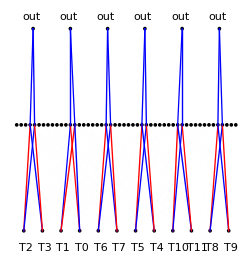

step = 10200 | total loss: 4.32e-03 | train loss: 3.80e-06 | reg: 4.31e+00 
step = 10400 | total loss: 4.32e-03 | train loss: 4.04e-06 | reg: 4.31e+00 
step = 10600 | total loss: 4.32e-03 | train loss: 4.80e-06 | reg: 4.31e+00 
step = 10800 | total loss: 4.32e-03 | train loss: 4.08e-06 | reg: 4.31e+00 
step = 11000 | total loss: 4.32e-03 | train loss: 4.40e-06 | reg: 4.31e+00 
step = 11200 | total loss: 4.31e-03 | train loss: 5.07e-06 | reg: 4.31e+00 
step = 11400 | total loss: 4.31e-03 | train loss: 4.52e-06 | reg: 4.31e+00 
step = 11600 | total loss: 4.32e-03 | train loss: 5.10e-06 | reg: 4.32e+00 
step = 11800 | total loss: 4.31e-03 | train loss: 5.28e-06 | reg: 4.31e+00 
step = 12000 | total loss: 4.32e-03 | train loss: 4.58e-06 | reg: 4.32e+00 


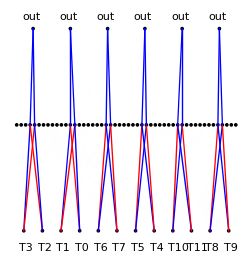

step = 12200 | total loss: 4.32e-03 | train loss: 4.14e-06 | reg: 4.31e+00 
step = 12400 | total loss: 4.32e-03 | train loss: 4.96e-06 | reg: 4.31e+00 
step = 12600 | total loss: 4.31e-03 | train loss: 3.93e-06 | reg: 4.31e+00 
step = 12800 | total loss: 4.31e-03 | train loss: 3.73e-06 | reg: 4.31e+00 
step = 13000 | total loss: 4.31e-03 | train loss: 4.96e-06 | reg: 4.31e+00 
step = 13200 | total loss: 4.31e-03 | train loss: 3.62e-06 | reg: 4.31e+00 
step = 13400 | total loss: 4.32e-03 | train loss: 4.10e-06 | reg: 4.31e+00 
step = 13600 | total loss: 4.31e-03 | train loss: 4.87e-06 | reg: 4.31e+00 
step = 13800 | total loss: 4.32e-03 | train loss: 4.40e-06 | reg: 4.31e+00 
step = 14000 | total loss: 4.32e-03 | train loss: 4.75e-06 | reg: 4.31e+00 


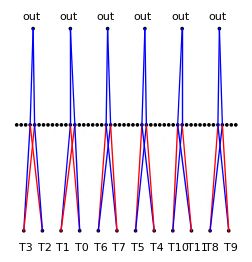

step = 14200 | total loss: 4.31e-03 | train loss: 3.54e-06 | reg: 4.31e+00 
step = 14400 | total loss: 4.32e-03 | train loss: 4.83e-06 | reg: 4.31e+00 
step = 14600 | total loss: 4.32e-03 | train loss: 4.01e-06 | reg: 4.31e+00 
step = 14800 | total loss: 4.32e-03 | train loss: 4.49e-06 | reg: 4.31e+00 
step = 15000 | total loss: 4.32e-03 | train loss: 4.44e-06 | reg: 4.32e+00 
step = 15200 | total loss: 4.32e-03 | train loss: 4.54e-06 | reg: 4.32e+00 
step = 15400 | total loss: 4.32e-03 | train loss: 4.27e-06 | reg: 4.32e+00 
step = 15600 | total loss: 4.32e-03 | train loss: 4.64e-06 | reg: 4.31e+00 
step = 15800 | total loss: 4.32e-03 | train loss: 4.52e-06 | reg: 4.32e+00 
step = 16000 | total loss: 4.32e-03 | train loss: 4.87e-06 | reg: 4.31e+00 


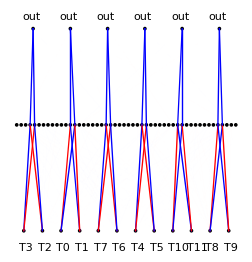

step = 16200 | total loss: 4.32e-03 | train loss: 3.99e-06 | reg: 4.31e+00 
step = 16400 | total loss: 4.32e-03 | train loss: 4.05e-06 | reg: 4.32e+00 
step = 16600 | total loss: 4.32e-03 | train loss: 4.75e-06 | reg: 4.31e+00 
step = 16800 | total loss: 4.32e-03 | train loss: 4.81e-06 | reg: 4.31e+00 
step = 17000 | total loss: 4.32e-03 | train loss: 4.22e-06 | reg: 4.32e+00 
step = 17200 | total loss: 4.32e-03 | train loss: 4.74e-06 | reg: 4.31e+00 
step = 17400 | total loss: 4.31e-03 | train loss: 4.36e-06 | reg: 4.31e+00 
step = 17600 | total loss: 4.32e-03 | train loss: 5.38e-06 | reg: 4.31e+00 
step = 17800 | total loss: 4.32e-03 | train loss: 4.27e-06 | reg: 4.32e+00 
step = 18000 | total loss: 4.32e-03 | train loss: 4.41e-06 | reg: 4.32e+00 


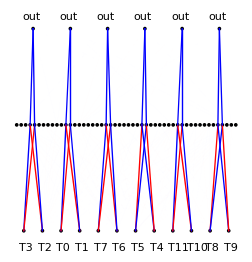

step = 18200 | total loss: 4.32e-03 | train loss: 4.61e-06 | reg: 4.32e+00 
step = 18400 | total loss: 4.32e-03 | train loss: 4.44e-06 | reg: 4.31e+00 
step = 18600 | total loss: 4.32e-03 | train loss: 3.70e-06 | reg: 4.32e+00 
step = 18800 | total loss: 4.32e-03 | train loss: 4.41e-06 | reg: 4.32e+00 
step = 19000 | total loss: 4.32e-03 | train loss: 5.25e-06 | reg: 4.31e+00 
step = 19200 | total loss: 4.32e-03 | train loss: 4.33e-06 | reg: 4.31e+00 
step = 19400 | total loss: 4.32e-03 | train loss: 4.58e-06 | reg: 4.32e+00 
step = 19600 | total loss: 4.32e-03 | train loss: 4.86e-06 | reg: 4.32e+00 
step = 19800 | total loss: 4.32e-03 | train loss: 4.47e-06 | reg: 4.32e+00 


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


# create model
seed = 3
np.random.seed(seed)
torch.manual_seed(seed)

# d_in = n_control + n_task
# d_out = 1
# shp = [d_in, 20, d_out]

shp = [12, 50, 6]

model = BioMLP(shp=shp)

n_task = 12
n_output = 6
in_formulas =  ["T%d"%jj for jj in np.arange(n_task)]
out_formulas = [r"out" for jj in np.arange(n_output)]

# training hyper-parameters
# train_type = 1; no L1
# train_type = 2; L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
train_type = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.0)
log = 200
lamb = 0 if train_type==1 else 0.001
swap_log = 200 if train_type >= 4 else float('inf')
weight_factor = 1. if train_type == 3 or train_type == 5 else 0.
plot_log = 2000
steps = 20000
 
    
frame_dir = 'frames'
os.makedirs(frame_dir, exist_ok=True)

for step in range(steps):
    
    optimizer.zero_grad()
    pred  = model(inputs)
    loss = torch.mean((pred-labels)**2)
    reg = model.get_cc(bias_penalize=True, weight_factor=weight_factor)
    
    total_loss = loss + lamb*reg
    total_loss.backward()
    optimizer.step()
    
    if step % log == 0:
        print("step = %d | total loss: %.2e | train loss: %.2e | reg: %.2e "%(step, total_loss.detach().numpy(), loss.detach().numpy(), reg.detach().numpy()))
    
    if (step+1) % swap_log == 0:
        model.relocate()

    if step % plot_log == 0:
        model.plot()
        fontsize = 8
        for j in range(shp[0]):
            plt.text(0.5/(2*shp[0])+j/shp[0], -0.03, in_formulas[model.in_perm[j].long()], fontsize=fontsize)

        for j in range(shp[-1]):
            plt.text(1/(2*shp[-1])+j/shp[-1]-0.05, 0.1*(len(shp)-1)+0.01, out_formulas[model.out_perm[j].long()], fontsize=fontsize)

        plt.show()
        
        # frame_filename = os.path.join(frame_dir, f'frame_{step}.png')
        # plt.savefig(frame_filename)
        # plt.close()

   
        
    

In [ ]:
import imageio
images = [imageio.imread(os.path.join(frame_dir, f'frame_{step}.png')) for step in range(0, steps, plot_log)]
imageio.mimsave('animation.gif', images, duration=0.2)